In [11]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt

# Restart the runtime by ending the process.
exit()

In [1]:
import os
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, NUM_BANDS, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS
from serving.common import list_blobs_with_prefix
from serving.hist_training import create_hist_dataset, train_and_evaluate, create_data_sample, get_labels #, LstmModel
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels
import logging
import io
import itertools
from google.cloud import storage
import google.auth
import time

from keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(features, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feature = {
        'feature': _bytes_feature(tf.io.serialize_tensor(features)),
        'label': _float_feature(label),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_dataset_to_gcp(dataset, bucket_name='vgnn', file_name='hist_dataset_medium.tfrecords'):
    # Initialize GCP client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Create a local temporary file
    local_file_name = 'temp_' + file_name
    
    # Write the dataset to the local file
    with tf.io.TFRecordWriter(local_file_name) as writer:
        for features, label in dataset:
            example = serialize_example(features, label)
            writer.write(example)
    
    # Upload the local file to GCS
    blob = bucket.blob(f"dataset/{file_name}")
    blob.upload_from_filename(local_file_name)

    # Remove the local temporary file
    os.remove(local_file_name)

    print(f"Dataset saved to gs://{bucket_name}/dataset/{file_name}")
    
def parse_tfrecord_fn(example_proto):
    # Define the features dictionary that matches the structure used when saving
    feature_description = {
        'feature': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([1],tf.float32)
    }
    
    # Parse the input tf.Example proto using the feature description
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode the feature from the parsed example
    feature = tf.io.parse_tensor(parsed_features['feature'], out_type=tf.float32)
    label = parsed_features['label']
    
    return feature, label

def load_dataset_from_gcp(bucket_name='vgnn', file_name='hist_dataset_medium.tfrecords'):
    # Construct the full GCS path
    gcs_path = f"gs://{bucket_name}/dataset/{file_name}"
    
    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(gcs_path)
    
    # Parse the TFRecords
    parsed_dataset = dataset.map(parse_tfrecord_fn)     
    
    return parsed_dataset    

In [3]:
# SETUP

CREATE_DATASET = False

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
batch_size = 10

client = storage.Client()
bucket = client.get_bucket(bucket_name)



In [4]:
if CREATE_DATASET:
    # Generate all prefixes
    start_time = time.perf_counter()
    
    labels_df = get_varied_labels(0,20)
    labels = list(zip(labels_df["county_name"],
                      labels_df["county_ansi"],
                 labels_df["state_ansi"],
                 labels_df["year"]))


    prefixes_hist = [f'histograms/{NUM_BINS}_bcukets/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                for county,_, fips, year in labels]

    # Batch check all prefixes
    results_hist = batch_check_blobs(bucket_name, prefixes_hist)

    # Generate get_input_img_params based on results
    get_input_img_params = [(county.capitalize(), fips, year)
                for county, county_fips, fips, year in labels
                if results_hist[f'histograms/{NUM_BINS}_bcukets/{SCALE}/{county.capitalize()}_{fips}/{year}']
    ]

    print(f"Number of items to process: {len(get_input_img_params)}")
    
    end_time_dataset_info = time.perf_counter()
    print(f"Collecting dataset information: {end_time_dataset_info-start_time}")
    
    dataset, input_shape = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy")
    end_time_dataset = time.perf_counter()
    
    print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")
    
    # Save dataset
    save_dataset_to_gcp(dataset, file_name = f"{NUM_BINS}_buckets_training_test")
    print("Dataset created")
else:
    dataset = load_dataset_from_gcp(file_name=f"{NUM_BINS}_buckets_training_test")
    for features, label in dataset.take(1):
        input_shape = tuple(features.shape)
        label_shape = label.shape
    print("Dataset loaded")

Dataset loaded


In [5]:
for features, label in dataset.take(1):
    input_shape = tuple(features.shape)

print(f"""input_shape :{input_shape}
dataset: {type(dataset)}""")

input_shape :(3, 1664)
dataset: <class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [6]:
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Sutter'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
66,CORN,YEAR,2016,06,CALIFORNIA,101,SUTTER,264.1,USDA_Corn_County_2016.csv
3045,CORN,YEAR,2018,06,CALIFORNIA,101,SUTTER,210.0,USDA_Corn_County_2018.csv
4389,CORN,YEAR,2019,06,CALIFORNIA,101,SUTTER,147.1,USDA_Corn_County_2019.csv
7314,CORN,YEAR,2021,06,CALIFORNIA,101,SUTTER,169.9,USDA_Corn_County_2021.csv
8791,CORN,YEAR,2022,06,CALIFORNIA,101,SUTTER,133.8,USDA_Corn_County_2022.csv


In [7]:
# Function to check shapes
def check_dataset_shapes(dataset, num_samples_to_check=5):
    for i, (features, label) in enumerate(dataset.take(num_samples_to_check)):
        print(f"Sample {i+1}:")
        print(f"  Features shape: {features.shape}")
        print(f"  Label shape: {label.shape}")
        if i == 0:
            first_shape = features.shape
        else:
            if features.shape != first_shape:
                print("Warning: Inconsistent feature shape detected!")
                break

# Check the shapes of the first few samples
check_dataset_shapes(dataset)

Sample 1:
  Features shape: (3, 1664)
  Label shape: (1,)
Sample 2:
  Features shape: (3, 1664)
  Label shape: (1,)
Sample 3:
  Features shape: (3, 1664)
  Label shape: (1,)
Sample 4:
  Features shape: (3, 1664)
  Label shape: (1,)
Sample 5:
  Features shape: (3, 1664)
  Label shape: (1,)


In [33]:
import keras
import matplotlib.pyplot as plt
import mlflow
import mlflow.tensorflow
import numpy as np
from keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
from mlflow.models import infer_signature

def set_seeds(seed=42):
    # Set seeds for Python's random module
    random.seed(seed)

    # Set seed for NumPy
    np.random.seed(seed)

    # Set seed for TensorFlow
    tf.random.set_seed(seed)

# Create a directory for MLflow artifacts
mlflow_artifacts_dir = os.path.abspath('mlflow_artifacts')
os.makedirs(mlflow_artifacts_dir, exist_ok=True)

# Set MLflow tracking URI to the local directory
mlflow.set_tracking_uri(f"file:{mlflow_artifacts_dir}")  

# Define the LSTM model
class LstmModel(keras.Model):
    def __init__(self, input_shape, lstm_layers=3, no_units=3, output_units=1, dropout_rate=0.2, mean_response=0):
        super(LstmModel, self).__init__()
        self.lstm_layers = lstm_layers
        self.no_units = no_units
        self.output_units = output_units
        self.dropout_rate = dropout_rate
        self.mean_response = mean_response

        # Define LSTM and Dense layers
        self.lstm_layers_list = [
            LSTM(units=no_units, return_sequences=(i < lstm_layers - 1), 
                 kernel_initializer='zeros', recurrent_initializer='zeros', bias_initializer='zeros')
            for i in range(lstm_layers)
        ]
        self.dense = Dense(units=output_units, kernel_initializer='zeros', 
                           bias_initializer=tf.keras.initializers.Constant(mean_response))
    
    @tf.function
    def call(self, inputs, training=False):
        #LSTM layers
        x = inputs
        
        for lstm_layer in self.lstm_layers_list:
            x = lstm_layer(x)
            
        outputs = self.dense(x)
        
        return outputs

    def summary(self):
        super(LstmModel, self).summary()
    
    def compile(self, optimizer='adam', loss='mse', metrics=[], learning_rate=0.001):
        self.learning_rate = learning_rate

        # Dictionary to map optimizer names to their classes
        optimizers = {
            'adam': Adam,
            'nadam': Nadam,
            'rms': RMSprop
        }

        # Get the optimizer class from the dictionary
        optimizer_class = optimizers.get(optimizer.lower(), Adam)

        # Instantiate the optimizer with the specified learning rate
        optimizer_instance = optimizer_class(learning_rate=learning_rate)

        # Compile the model with the chosen optimizer, loss, and metrics
        tf.config.run_functions_eagerly(True)
        super(LstmModel, self).compile(optimizer=optimizer_instance, loss=loss, metrics=metrics)
        
    def fit(self, dataset, epochs=10, batch_size=32):

        class MyModel(mlflow.pyfunc.PythonModel):
            def predict(self, ctx, model_input, params):
                return list(params.values())

        # Set up MLflow experiment
        mlflow.set_experiment('LSTM_Experiment')
        
        # Shuffle and batch the dataset
        dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

        # Split the dataset
        val_size = 5
        val_dataset = dataset.take(val_size)
        train_dataset = dataset.skip(val_size)        

        # Start MLflow run


        with mlflow.start_run():
            # Early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            # Create a history callback
            history_callback = tf.keras.callbacks.History()
           
            # Train the model
            history = super(LstmModel, self).fit(train_dataset, epochs=epochs, batch_size=batch_size,
                           validation_data=val_dataset, callbacks=[early_stopping, history_callback])

            # Log model and parameters to MLflow
            # Create an example input
            for features, _ in dataset.take(1):
                example_input = features.numpy()
            signature = infer_signature(["input"], ["output"])
            model_info = mlflow.pyfunc.log_model(
                python_model=MyModel(), artifact_path="my_model", signature=signature
            )
            loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
            mlflow.log_param('epochs', epochs)
            mlflow.log_param('batch_size', batch_size)
            mlflow.log_param('lstm_layers', self.lstm_layers)
            mlflow.log_param('learning_rate', self.learning_rate)
            
            # Plot training progress
            self.plot_training_progress(history)            

            # Evaluate the model
            loss = super(LstmModel, self).evaluate(val_dataset)
            mlflow.log_metric('val_loss', loss)
        
        return history

    def plot_training_progress(self, history):
        # Plot training and validation loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.tight_layout()
        plt.show()        

136.66481
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 2174.1299 - val_loss: 1745.4976
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - loss: 2551.1362 - val_loss: 2070.4021
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - loss: 2177.9797 - val_loss: 2207.8625
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step - loss: 1701.7292 - val_loss: 2394.1057


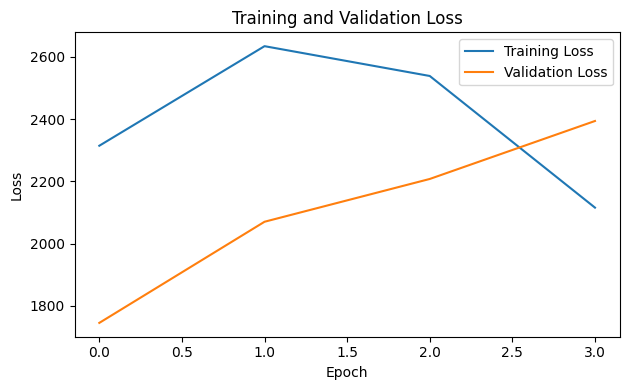

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 1825.3015


C:\Users\tskor\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [34]:
# # Create a directory for MLflow artifacts
# mlflow_artifacts_dir = os.path.abspath('mlflow_artifacts')
# os.makedirs(mlflow_artifacts_dir, exist_ok=True)

# # Set MLflow tracking URI
# mlflow.set_tracking_uri(f"file:{mlflow_artifacts_dir}")

responses = []
for _, response in dataset:
    responses.append(response.numpy())
mean_response = np.mean(responses)
print(mean_response)

model = LstmModel(input_shape=input_shape, lstm_layers=7, no_units=5, mean_response=mean_response)
model.compile(optimizer='adam')
history = model.fit(dataset, epochs=100, batch_size=batch_size)

In [ ]:
plt.ion()
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()